# Using Variational Autoencoder to Generate Faces

In this example, we are going to use VAE to generate faces. The dataset we are going to use is [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). The dataset consists of more than 200K celebrity face images. You have to download the Align&Cropped Images from the above website to run this example.

In [1]:
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.dataset import mnist
import datetime as dt
from bigdl.util.common import *
from glob import glob
import os
import scipy.misc
import numpy as np
from utils import *

image_size = 148
Z_DIM = 128
ENCODER_FILTER_NUM = 32
DATA_PATH = "/tmp/celeba/img_align_celeba" # please replace this

init_engine()

## Define the Model

Here, we define a slightly more complicate CNN networks using convolution (or deconv for upsample), batchnorm, and leakyRelu.

In [2]:
def conv_bn_lrelu(in_channels, out_channles, kw=4, kh=4, sw=2, sh=2, pw=-1, ph=-1):
    model = Sequential()
    model.add(SpatialConvolution(in_channels, out_channles, kw, kh, sw, sh, pw, ph))
    model.add(SpatialBatchNormalization(out_channles))
    model.add(LeakyReLU(0.2))
    return model

def deconv_bn_lrelu(in_channels, out_channles, kw=4, kh=4, sw=2, sh=2, pw=0, ph=0):
    model = Sequential()
    model.add(SpatialFullConvolution(in_channels, out_channles, kw, kh, sw, sh, pw, ph))
    model.add(SpatialBatchNormalization(out_channles))
    model.add(LeakyReLU(0.2))
    return model

In [3]:
def get_encoder_cnn():
    input0 = Input()
    
    #CONV
    conv1 = conv_bn_lrelu(3, 32)(input0) # 32 * 32 * 32
    conv2 = conv_bn_lrelu(32, 64)(conv1) # 16 * 16 * 64
    conv3 = conv_bn_lrelu(64, 128)(conv2) # 8 * 8 * 128
    conv4 = conv_bn_lrelu(128, 256)(conv3) # 4 * 4 * 256
    view = View([4*4*256])(conv4)
    
    # fully connected to generate mean and log-variance
    mean = Linear(4*4*256, Z_DIM)(view)
    log_variance = Linear(4*4*256, Z_DIM)(view)
    
    model = Model([input0], [mean, log_variance])
    return model

In [4]:
def get_decoder_cnn():
    input0 = Input()
    
    linear = Linear(Z_DIM, 4*4*256)(input0)
    reshape = Reshape([256, 4, 4])(linear)
    bn = SpatialBatchNormalization(256)(reshape)
    
    # upsampling
    deconv1 = deconv_bn_lrelu(256, 128, pw=1, ph=1)(bn) # 8 * 8 * 128
    deconv2 = deconv_bn_lrelu(128, 64, pw=1, ph=1)(deconv1) # 16 * 16 * 64
    deconv3 = deconv_bn_lrelu(64, 32, pw=1, ph=1)(deconv2) # 32 * 32 * 32
    deconv4 = deconv_bn_lrelu(32, 3, pw=1, ph=1)(deconv3) # 64 * 64 * 3
    output = Tanh()(deconv4)
    
    model = Model([input0], [output])
    return model

In [5]:
def get_autoencoder_cnn():
    input0 = Input()
    encoder = get_encoder_cnn()(input0)
    sampler = GaussianSampler()(encoder)
    
    decoder_model = get_decoder_cnn()
    decoder = decoder_model(sampler)
    
    model = Model([input0], [encoder, decoder])
    return model, decoder_model

In [6]:
model, decoder = get_autoencoder_cnn()

creating: createInput
creating: createInput
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createView
creating: createLinear
creating: createLinear
creating: createModel
creating: createGaussianSampler
creating: createInput
creating: createLinear
creating: createReshape
creating: createSpatialBatchNormalization
creating: createSequential
creating: createSpatialFullConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialFullConvolution
crea

## Load the Dataset

In [7]:
def get_data():
    data_files = glob(os.path.join(DATA_PATH, "*.jpg"))
    
    rdd_train_images = sc.parallelize(data_files[:100000]) \
                              .map(lambda path: get_image(path, image_size).transpose(2, 0, 1))
    rdd_train_sample = rdd_train_images.map(lambda img: Sample.from_ndarray(img, [np.array(0.0), img]))
    return rdd_train_sample

In [8]:
train_data = get_data()

## Define the Training Objective

In [9]:
criterion = ParallelCriterion()
criterion.add(KLDCriterion(), 1.0 * 0.002) # You may want to twick this parameter
criterion.add(MSECriterion(), 1.0)

creating: createParallelCriterion
creating: createKLDCriterion
creating: createMSECriterion


## Define the Optimizer

In [10]:
batch_size = 100


# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=train_data,
    criterion=criterion,
    optim_method=Adam(0.001, beta1=0.5),
    end_trigger=MaxEpoch(10),
    batch_size=batch_size)


app_name='autoencoder-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)


optimizer.set_train_summary(train_summary)

print "saving logs to ",app_name

creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createTrainSummary
saving logs to  autoencoder-20171226-155654


## Spin Up the Training

This could take a while, ranging from 1 hour to several hours depending on your system. You can use a less data by changing the "Load the Dataset" section, but the performce may not as good.

In [11]:
redire_spark_logs()
show_bigdl_info_logs()
trained_model = optimizer.optimize()

In [12]:
import matplotlib
matplotlib.use('Agg')
%pylab inline

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


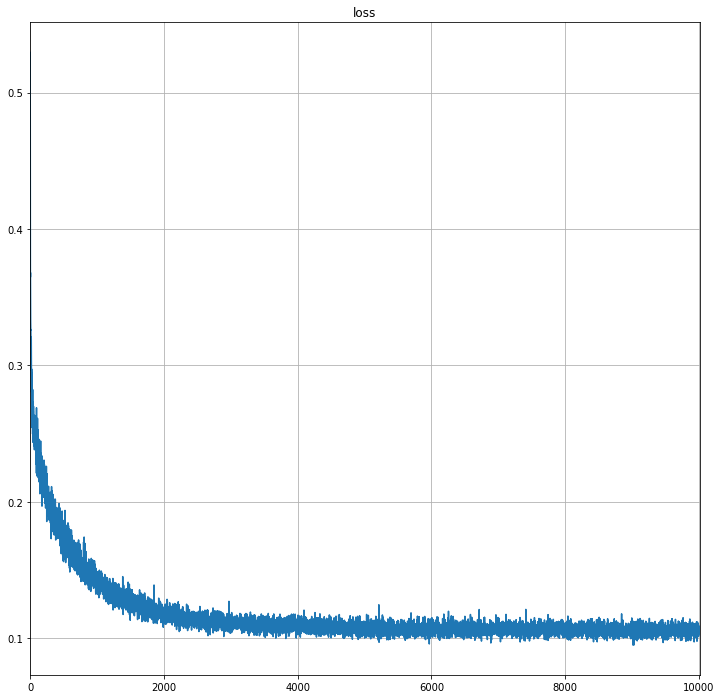

In [13]:
loss = np.array(train_summary.read_scalar("Loss"))

plt.figure(figsize = (12,12))
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

## Random Sample Some Images

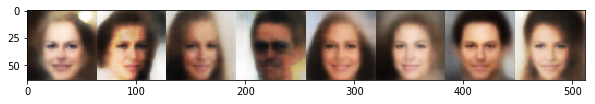

In [15]:
from matplotlib.pyplot import imshow
plt.figure(figsize=(10,80))
img = np.column_stack([decoder.forward(np.random.randn(1, 128)).reshape(3, 64,64).transpose(1, 2, 0) for s in range(8)])
imshow(inverse_transform(img))